# Medical Expenditure Panel Survey

This is explanatory analysis of medical expenses related to medical treatments. This is a regression problem.
In this work I trained and compared 2 models:
- Gradient Boosting Regressor
- Random Forest Regressor

Health Expenses were also limited to maximum of 150k$.

For the explanations I have selected variables:
- __PCS42__: PHY COMPONENT SUMMRY SF-12V2 IMPUTED
- __MCS42__: MNT COMPONENT SUMMRY SF-12V2 IMPUTED
- __K6SUM42__: SAQ 30 DAYS: OVERALL RATING OF FEELINGS
- __PHQ242__: SAQ 2 WKS: OVERALL RATING OF FEELINGS
- __ARTHYPE__: TYPE OF ARTHRITIS DIAGNOSED
- __INCOME_M__: ANNUAL INCOME
- __CANCERDX__: CANCER DIAGNOSIS
- __AGE31X__: AGE - R3/1 (EDITED/IMPUTED)

# 2. GradientBoostingRegressor and Random Forest Regression

## 2.1 Partial Dependence Profiles

Below I have presented plots for Partial Dependence Profiles for selected variables. First variable __AGE31X__ has almost the same profile for both models, but for RandomForest Regressor it is more sensitive when age is larger then 50 years, then it starts to rise, while Gradient Boosting Regressor doesn't change its output.

__CANCERDX__ behaves the same for both models, for values <= 1 the predicted value stays the same, while for value that equals 2, it goes down a bit.

For __INCOME_M__ Gradient Boosting Regressor is more sensitive for values greater then 200k, it could be due to the model structure. Here both models have the same value predicted for variable value < 200k and don't change too much, while both model outputs start to rise, but with different dynamic. Gradient Boosting model tends to achieve higher output values.

__K6SUM42__ for min/max values of this variable behaves differently for both models, but between them both models have the same output. For Random Forest model, the plot shows that the output rises steadily with the increase of the variable, but for Gradient Boosting Regressor the output at the beginning starts to fall from some initial value, later it behaves just like Random Forest Model and when the variables value closes to 20, the GBR models response is more dynamic then RF.

__MCS42__ and __PCS42__ behave the same for both models. __MCS42__ is steady with small perturbations for Gradient Boosting Regressor model and almost constant for Random Forest. __PCS42__ is reverse U shaped for both models with this difference that for Random Forest it starts to decline faster.

__PHQ242__ for values greater then 4 have different pdp plots, where Gradient Boosting Regressor is more sensitive for the given variable. Here Random Forest model rises slowly with the increase of the variables value, while Gradient Boosting Model also increases but starts to oscilate with the tendence to increase. 

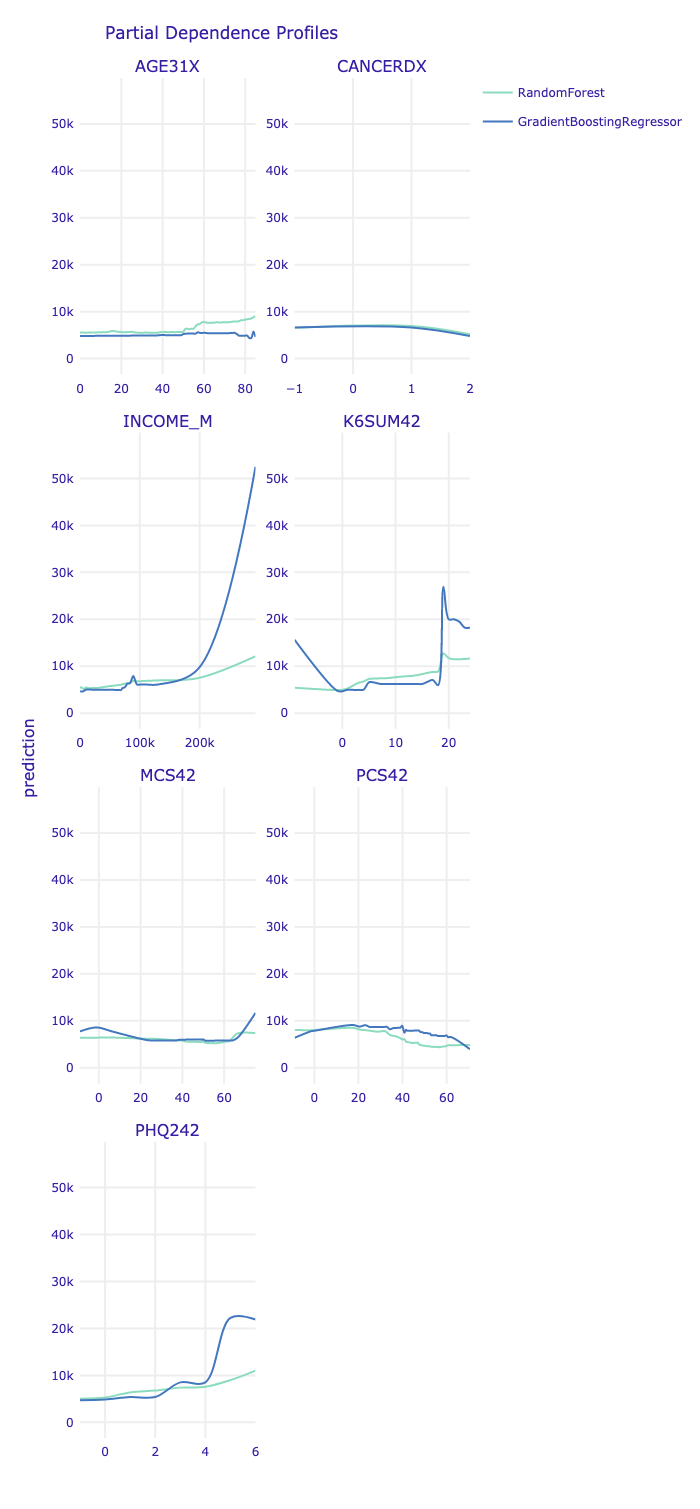

In [230]:
from IPython.display import Image
Image(filename='img/fig1.png')

## 2.2 Accumulated Local Dependence

In the chart below I presented Accumulated Local Dependence plots. Here these plots are quite alike like PDP, but with this difference that the values of the predicted value are for Gradient Boosting Regressor for viariable __K6SUM42__ are smaller then for PDP but they have the same shape. The same could be observed for variable __PHQ242__, where in PDP for Gradient Boosting Regressor model they tend to achieve higher predictions for values > 4.

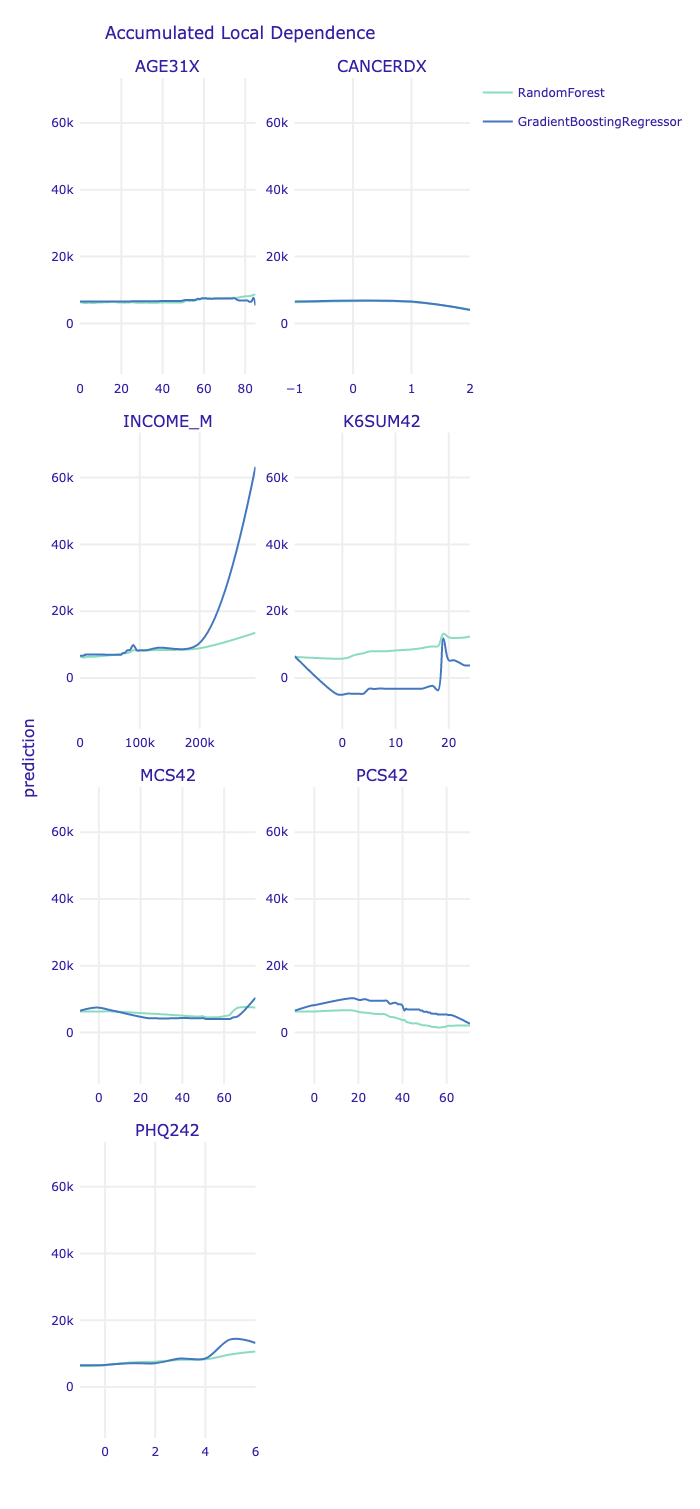

In [231]:
Image(filename='img/fig2.png')

# Appendix

In [36]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dalex as dx

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from aix360.datasets import MEPSDataset


pd.options.display.max_columns = 150

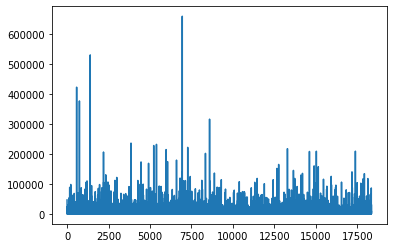

In [62]:
data = MEPSDataset().data()
data.reset_index(drop=True, inplace=True)
data.drop(columns= ['PANEL', 'PERSONWT'], inplace=True)
data_filtered = data[data['HEALTHEXP'] < 150000]
plt.plot(data.HEALTHEXP)

In [119]:
cols = data.columns
categoricalCols = [
    'REGION','GENDER', 'RACE3', 'MARRY31X','EDRECODE','FTSTU31X','ACTDTY31','HONRDC31',
    'RTHLTH31','MNHLTH31','HIBPDX','CHDDX','ANGIDX','MIDX','OHRTDX','STRKDX','EMPHDX',
    'CHBRON31','CHOLDX','CANCERDX','DIABDX','JTPAIN31','ARTHDX', 'ARTHTYPE','ASTHDX',
    'ADHDADDX','PREGNT31','WLKLIM31','ACTLIM31','SOCLIM31','COGLIM31','DFHEAR42',
    'DFSEE42','ADSMOK42','PHQ242','EMPST31','POVCAT15','INSCOV15'
]
X, y = data.drop({'HEALTHEXP'}, 1), data['HEALTHEXP']
X_cat = X.copy()
for cat in categoricalCols:
    X_cat[cat] = X_cat[cat].astype('int')

In [120]:
def score_r2_print(clf, X_train, X_test, y_train, y_test):
    print('Training R^2:', r2_score(y_train, clf.predict(X_train)))
    print('Test R^2:', r2_score(y_test, clf.predict(X_test)))

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X_cat, y, test_size=0.2, random_state=37)

# 1 Training models

## 1.1. Linear Regression

In [122]:
slr = LinearRegression()
slr.fit(X_train, y_train)
score_r2_print(slr, X_train, X_test, y_train, y_test)

Training R^2: 0.13815388907360537
Test R^2: 0.1776970270831072


In [123]:
y_test_pred = slr.predict(X_test)
y_train_pred = slr.predict(X_train)

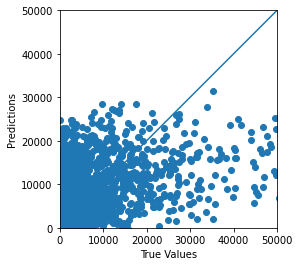

In [124]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, y_test_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# 1.2. RandomForestRegressor

In [125]:
from sklearn.ensemble import RandomForestRegressor

tree = RandomForestRegressor(
    n_estimators=900, 
    criterion='mse', 
    random_state=1,
    max_features="sqrt",
    n_jobs=-1)
tree.fit(X_train, y_train)
score_r2_print(tree, X_train, X_test, y_train, y_test)

Training R^2: 0.881080381454145
Test R^2: 0.18780782607953128


## 1.3. GradientBoostingRegressor

In [126]:
gbr = GradientBoostingRegressor(n_estimators=200, random_state=7, max_features="log2")
gbr.fit(X_train, y_train)

score_r2_print(gbr, X_train, X_test, y_train, y_test)

Training R^2: 0.35682813592631
Test R^2: 0.19676710164305644


# 2. Variable importance

In [127]:
def predict_function(model, data):
    return model.predict(data)

In [173]:
exp_gbr = dx.Explainer(gbr, X_test, y_test, predict_function=predict_function, label='GradientBoostingRegressor')

Preparation of a new explainer is initiated

  -> data              : 3670 rows 43 cols
  -> target variable   : Argument 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3670 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingRegressor (default)
  -> label             : GradientBoostingRegressor
  -> predict function  : <function predict_function at 0x1c8080830> will be used
  -> predicted values  : min = -4994.610647713694, mean = 5426.865425442358, max = 90340.6300457942
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -89892.6300457942, mean = -426.9678777584338, max = 285222.82490959356
  -> model_info        : package sklearn

A new explainer has been created!


# 2.1 Gradient Boosting Regressor model performance

In [174]:
mp_gbr = exp_gbr.model_performance("regression")
mp_gbr.result

,mse,rmse,r2,mae,mad
0,1.448404e+08,12034.963769,0.196767,4960.09368,2180.022726


In [175]:
vi_gbr = exp_gbr.model_parts()

In [176]:
vi_gbr.plot(max_vars=50, rounding_function=np.rint, digits=None, vertical_spacing=0.15)

# 2.2 Random Forest Regression model performance

In [219]:
exp_rf = dx.Explainer(tree, X_test, y_test, predict_function=predict_function, label='RandomForest')

Preparation of a new explainer is initiated

  -> data              : 3670 rows 43 cols
  -> target variable   : Argument 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3670 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : RandomForest
  -> predict function  : <function predict_function at 0x1c8080830> will be used
  -> predicted values  : min = 27.08353960364254, mean = 5730.65729768756, max = 45910.73222222222
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -45627.73222222222, mean = -730.7597500036354, max = 289922.6566666667
  -> model_info        : package sklearn

A new explainer has been created!


In [214]:
mp_rf = exp_rf.model_performance("regression")
mp_rf.result

,mse,rmse,r2,mae,mad
0,1.464559e+08,12101.896755,0.187808,5140.787297,2331.716667


In [215]:
vi_rf = exp_rf.model_parts()

In [216]:
vi_rf.plot(max_vars=50, rounding_function=np.rint, digits=None, vertical_spacing=0.15)

In [211]:
selected_variables = ['PCS42', 'MCS42', 'K6SUM42', 'PHQ242', 'ARTHYPE', 'INCOME_M', 'CANCERDX', 'AGE31X']

In [225]:
pdp_gbr = exp_gbr.model_profile(type = 'partial', N=50, variables=selected_variables)

Calculating ceteris paribus!: 100%|██████████| 43/43 [00:00<00:00, 191.21it/s]


In [226]:
ale_gbr = exp_gbr.model_profile(type='accumulated', variables=selected_variables)

Calculating ceteris paribus!: 100%|██████████| 43/43 [00:00<00:00, 66.23it/s]
/Users/piotrpodolski/Desktop/projects/IML/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

Calculating accumulated dependency!: 100%|██████████| 7/7 [00:01<00:00,  5.06it/s]


In [227]:
pdp_rf = exp_rf.model_profile(type = 'partial', N=50, variables=selected_variables)
plt = pdp_rf.plot(pdp_gbr, title="Partial Dependence Profiles", show=False)
plt.write_image("img/fig1.png")

Calculating ceteris paribus!: 100%|██████████| 43/43 [00:05<00:00,  8.40it/s]


In [228]:
ale_rf = exp_rf.model_profile(type='accumulated', variables=selected_variables)
plt = ale_rf.plot(ale_gbr, title="Accumulated Local Dependence", show=False)
plt.write_image("img/fig2.png")
plt.show()

Calculating ceteris paribus!: 100%|██████████| 43/43 [00:10<00:00,  4.11it/s]
/Users/piotrpodolski/Desktop/projects/IML/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version

Calculating accumulated dependency!: 100%|██████████| 7/7 [00:01<00:00,  5.36it/s]
